In [44]:
!pip3 install imageio


     ---------------------------------------- 3.4/3.4 MB 2.8 MB/s eta 0:00:00


In [146]:
import pandas as pd
import fastparquet
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp
import os
from fastparquet import ParquetFile
import folium
import shutil
from scipy.interpolate import griddata
from folium import plugins
from folium.plugins import HeatMap
import datetime
import geojsoncontour
from selenium import webdriver
import time
from scipy.interpolate import Rbf


from pathlib import Path
import imageio
from PIL import Image, ImageFont, ImageDraw

In [2]:
path = "./dataset"
files = [file for file in os.listdir(path) if not file.startswith('.')]
all_months_data = pd.DataFrame()
for file in files:
    current_data = ParquetFile(path+"/"+file).to_pandas()
    all_months_data = pd.concat([all_months_data, current_data])
all_months_data.to_csv("yearlyAnalysis.csv", index=False)

In [3]:
combined_data = pd.read_csv("yearlyAnalysis.csv")
combined_data.head()

,airQualityLevel,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,co2.avgOverTime,pm10.avgOverTime,co.avgOverTime,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime
0,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,71.0,0.0,32.97,16.94,322.99,35.48,3.04,78.51,21.30,4.52,74.53,0.06,62.28,0.46
1,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,NO2,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,99.0,0.0,1.21,48.09,525.40,82.88,1.32,125.37,23.29,3.23,76.57,2.42,58.05,0.94
2,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,NO2,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,81.0,0.0,14.09,32.27,424.46,76.27,1.32,85.96,21.65,24.61,71.48,0.24,55.42,0.93
3,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,NO2,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,97.0,0.0,24.03,47.48,162.78,94.92,1.14,97.11,22.06,1.39,84.27,4.80,60.90,0.89
4,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,72.0,0.0,30.78,58.04,0.00,96.20,1.83,75.28,22.36,2.89,81.63,4.30,62.43,0.94


In [4]:
# getting the columns
combined_data.columns

Index(['airQualityLevel', 'observationDateTime', 'deviceStatus',
       'aqiMajorPollutant', 'id', 'airQualityIndex', 'uv.avgOverTime',
       'o3.avgOverTime', 'pm2p5.avgOverTime', 'co2.avgOverTime',
       'pm10.avgOverTime', 'co.avgOverTime', 'no2.avgOverTime',
       'airTemperature.avgOverTime', 'illuminance.avgOverTime',
       'ambientNoise.avgOverTime', 'so2.avgOverTime',
       'relativeHumidity.avgOverTime', 'atmosphericPressure.avgOverTime'],
      dtype='object')

## Cleaning the Data

In [5]:
combined_data['observationDateTime'] =  pd.to_datetime(combined_data['observationDateTime'])
combined_data["observationDateTime"]

0        2022-01-31 23:31:25+05:00
1        2022-01-31 23:31:25+05:00
2        2022-01-31 23:31:25+05:00
3        2022-01-31 23:31:25+05:00
4        2022-01-31 23:31:25+05:00
                    ...           
206656   2022-01-30 23:16:32+05:00
206657   2022-01-30 23:16:32+05:00
206658   2022-01-30 23:16:32+05:00
206659   2022-01-30 23:16:32+05:00
206660   2022-01-30 23:16:32+05:00
Name: observationDateTime, Length: 206661, dtype: datetime64[ns, pytz.FixedOffset(300)]

In [6]:
combined_data.dropna(inplace=True)
combined_data.reset_index(inplace=True)

In [7]:
combined_data.isnull().sum()

index                              0
airQualityLevel                    0
observationDateTime                0
deviceStatus                       0
aqiMajorPollutant                  0
id                                 0
airQualityIndex                    0
uv.avgOverTime                     0
o3.avgOverTime                     0
pm2p5.avgOverTime                  0
co2.avgOverTime                    0
pm10.avgOverTime                   0
co.avgOverTime                     0
no2.avgOverTime                    0
airTemperature.avgOverTime         0
illuminance.avgOverTime            0
ambientNoise.avgOverTime           0
so2.avgOverTime                    0
relativeHumidity.avgOverTime       0
atmosphericPressure.avgOverTime    0
dtype: int64

### Reading Location FIle

In [8]:
location_data=pd.read_csv("location.csv")
location_dict={}
for index, row in location_data.iterrows():
    location_dict[row['id']]={
        'coordinates':[row['latitude'], row['longitude']],
        'label':row['label']
    }
location_dict

{'datakaveri.org/04a15c9960ffda227e9546f3f46e629e1fe4132b/rs.iudx.org.in/pune-env-aqm/f36b4669-628b-ad93-9970-f9d424afbf75': {'coordinates': [73.88559,
   18.538425],
  'label': 'Blue Diamond Square (Hotel Taj)_10'},
 'datakaveri.org/04a15c9960ffda227e9546f3f46e629e1fe4132b/rs.iudx.org.in/pune-env-aqm/10b6d0f8-ae93-6622-5d1b-76af4bebc11e': {'coordinates': [73.836817,
   18.572774],
  'label': 'BopadiSquare_32'},
 'datakaveri.org/04a15c9960ffda227e9546f3f46e629e1fe4132b/rs.iudx.org.in/pune-env-aqm/98bf83b7-a2b8-ea70-88aa-7d1d9f33dbe0': {'coordinates': [73.812648,
   18.560589],
  'label': 'Bremen Square_37'},
 'datakaveri.org/04a15c9960ffda227e9546f3f46e629e1fe4132b/rs.iudx.org.in/pune-env-aqm/21ece4ba-0dcf-843a-16e0-35e0082277dd': {'coordinates': [73.783532,
   18.507789],
  'label': 'Chandani Square_25'},
 'datakaveri.org/04a15c9960ffda227e9546f3f46e629e1fe4132b/rs.iudx.org.in/pune-env-aqm/17429134-c3d7-da41-0057-388a28723913': {'coordinates': [73.85259,
   18.513701],
  'label': 'Chi

#### Mapping the sensors into the map 

In [9]:
sensors_map=folium.Map()
for location_id, location_info in location_dict.items():
    folium.Marker([location_info["coordinates"][1], location_info["coordinates"][0]],
                  tooltip=location_info['label']).add_to(sensors_map)
sensors_map.fit_bounds(sensors_map.get_bounds())
sensors_map

In [10]:
# adding sensor location and label information to the dataframe
combined_data['latitude']=combined_data['id'].apply(lambda id:location_dict[id]['coordinates'][0])
combined_data['longitude']=combined_data['id'].apply(lambda id:location_dict[id]['coordinates'][1])
combined_data['label']=combined_data['id'].apply(lambda id:location_dict[id]['label'])
combined_data

,index,airQualityLevel,observationDateTime,deviceStatus,aqiMajorPollutant,id,airQualityIndex,uv.avgOverTime,o3.avgOverTime,pm2p5.avgOverTime,...,no2.avgOverTime,airTemperature.avgOverTime,illuminance.avgOverTime,ambientNoise.avgOverTime,so2.avgOverTime,relativeHumidity.avgOverTime,atmosphericPressure.avgOverTime,latitude,longitude,label
0,0,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,71.0,0.0,32.97,16.94,...,78.51,21.30,4.52,74.53,0.06,62.28,0.46,73.878603,18.502865,Golibar Square_11
1,1,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,NO2,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,99.0,0.0,1.21,48.09,...,125.37,23.29,3.23,76.57,2.42,58.05,0.94,73.876484,18.525007,Sadhu_Wasvani_Square_24
2,2,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,NO2,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,81.0,0.0,14.09,32.27,...,85.96,21.65,24.61,71.48,0.24,55.42,0.93,73.753850,18.553421,Susgaon_46
3,3,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,NO2,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,97.0,0.0,24.03,47.48,...,97.11,22.06,1.39,84.27,4.80,60.90,0.89,73.868533,18.519513,Power_House_Square_43
4,4,SATISFACTORY,2022-01-31 23:31:25+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,72.0,0.0,30.78,58.04,...,75.28,22.36,2.89,81.63,4.30,62.43,0.94,73.848224,18.522881,Jhanshi Rani Square_59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169444,206656,MODERATE,2022-01-30 23:16:32+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,100.0,0.0,8.55,31.46,...,75.02,22.56,3.29,72.09,3.25,56.29,0.94,73.783532,18.507789,Chandani Square_25
169445,206657,MODERATE,2022-01-30 23:16:32+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,109.0,0.0,0.00,41.08,...,105.07,22.41,2.62,78.20,2.49,56.14,0.94,73.885590,18.538425,Blue Diamond Square (Hotel Taj)_10
169446,206658,SATISFACTORY,2022-01-30 23:16:32+05:00,ACTIVE,PM10,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,85.0,0.0,8.51,49.82,...,81.90,20.89,24.81,72.40,0.00,58.08,0.93,73.753850,18.553421,Susgaon_46
169447,206659,MODERATE,2022-01-30 23:16:32+05:00,ACTIVE,CO,datakaveri.org/04a15c9960ffda227e9546f3f46e629...,105.0,0.0,0.00,74.10,...,108.52,23.13,19.65,75.39,1.37,52.31,0.93,73.952635,18.486640,FursungiKaman_31


In [11]:
sensor_ids = combined_data['id'].unique() ## Uniquely 50 sensors are present in the pune city
path="./sensorData"
if os.path.exists(path):
    shutil.rmtree(path)
os.makedirs(path)
for sensorid in sensor_ids:
    df=combined_data.loc[combined_data['id']==sensorid]
    mypath = "./sensorData/"+df['label'].unique()[0] +'.csv'
    df.to_csv(mypath,index=False)

## Interpolating the values of pollution on the whole latitude

Reference : https://towardsdatascience.com/visualizing-spatial-data-with-geojson-heatmaps-1fbe2063ab86

In [128]:
def interpolate_pollutant(pollutant,date,month,time):
    pollutant=pollutant+'.avgOverTime'
    df=combined_data[['observationDateTime','id', pollutant,'latitude','longitude','label']]
    df=df[(df['observationDateTime'].dt.day==date) & (df['observationDateTime'].dt.month==month)]
    final=df.groupby('label').mean()
    final=final[~(final[pollutant]== 0)]
    latitude=final['latitude']
    longitude=final['longitude']
    zvalue=final[pollutant]
    
    
    grid_x, grid_y = np.mgrid[latitude.min()-0.01:latitude.max()+0.01:0.001, longitude.min()-0.01:longitude.max()+0.01:0.001]

    # Make an n-dimensional interpolator. This is essential line number 4.
    rbfi = Rbf(latitude, longitude, zvalue,function='gaussian')

    # Predict on the regular grid. Line 5.
    di = rbfi(grid_x, grid_y)
    cs=mp.contourf(grid_x,grid_y,di,levels=45,cmap=mp.cm.jet)

    #Converting matplotplib contour plot to geojson
    geojson = geojsoncontour.contourf_to_geojson(
            contourf=cs,
            min_angle_deg=3.0,
            ndigits=5,
            stroke_width=1,
            fill_opacity=0.5)

    #reading geojson as dict
    price_geojson=eval(geojson)

    sensors_map=folium.Map(tiles="cartodbpositron")
    for location_id, location_info in location_dict.items():
        folium.Marker([location_info["coordinates"][1], location_info["coordinates"][0]],
                      tooltip=location_info['label']).add_to(sensors_map)
    folium.GeoJson(
            geojson,
            style_function=lambda x: {
                'color':     x['properties']['stroke'],
                'weight':    x['properties']['stroke-width'],
                'fillColor': x['properties']['fill'],
                'opacity':   0.1,
            }).add_to(sensors_map)

    sensors_map.fit_bounds(sensors_map.get_bounds())
    savePath='./timelapse/' + str(date)  +'_1_2022_'+str(time)+'.html'
    sensors_map.save(savePath)

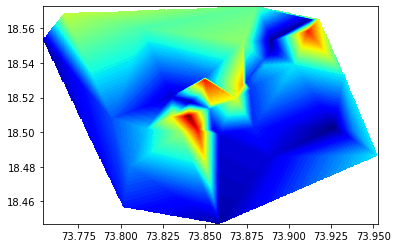

In [13]:
interpolate_pollutant('pm10',12,2,5)

# Section to explain

In [14]:
# data on 15th January, 2022 at 5am

pollutant='co2'
pollutant=pollutant+'.avgOverTime'
df=combined_data[['observationDateTime','id', pollutant,'latitude','longitude','label']]
df=df[(df['observationDateTime'].dt.day==28) & (df['observationDateTime'].dt.month==1)]

In [15]:
final=df.groupby('label').mean()
final=final[~(final['co2.avgOverTime']== 0)]
latitude=final['latitude']
longitude=final['longitude']
zvalue=final['co2.avgOverTime']

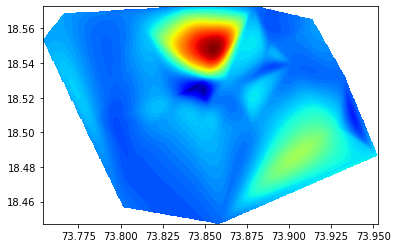

In [97]:
#Interpolating values to get better coverage
xi = np.linspace(latitude.min(),latitude.max(),300);
yi = np.linspace(longitude.min(),longitude.max(),300);
zi = griddata((latitude, longitude), zvalue, (xi[None,:], yi[:,None]), method='cubic')


#Creating contour plot with a step size of 1000
step_size=1000
# cs = mp.contourf(xi,yi,zi,range(5000,int( np.nanmax(zi))+step_size,step_size),cmap=mp.cm.jet)cs=
cs=mp.contourf(xi, yi, zi, levels=100,cmap=mp.cm.jet)

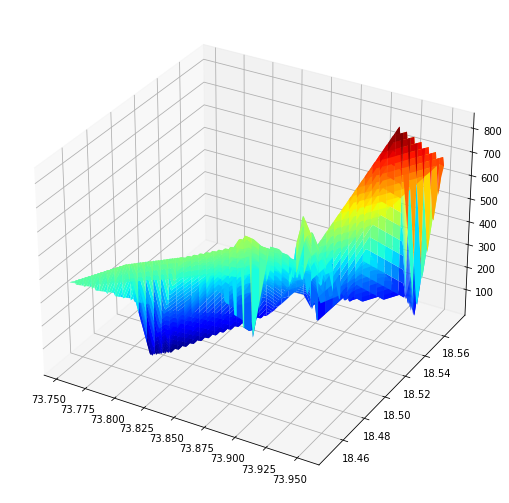

In [17]:
# Creating figure
my_cmap = mp.get_cmap('hot')
fig = mp.figure(figsize =(14, 9))
ax = mp.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(xi, yi, zi,cmap=mp.cm.jet)
 
# show plot
mp.show()

In [104]:
grid_x, grid_y = np.mgrid[latitude.min()-0.01:latitude.max()+0.01:0.001, longitude.min()-0.01:longitude.max()+0.01:0.001]

# Make an n-dimensional interpolator. This is essential line number 4.
rbfi = Rbf(latitude, longitude, zvalue,function='gaussian')

# Predict on the regular grid. Line 5.
di = rbfi(grid_x, grid_y)

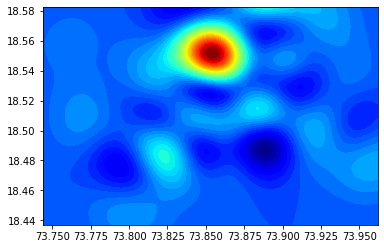

In [127]:
cs=mp.contourf(grid_x,grid_y,di,levels=45,cmap=mp.cm.jet)

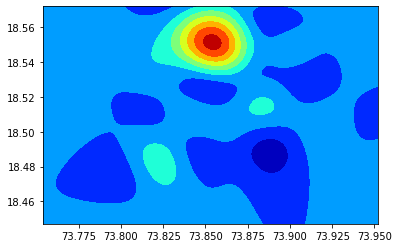

In [92]:
cs=mp.contourf(grid_x,grid_y,di,cmap=mp.cm.jet)

array([[73.75385, 73.75385, 73.75385, ..., 73.75385, 73.75385, 73.75385],
       [73.75485, 73.75485, 73.75485, ..., 73.75485, 73.75485, 73.75485],
       [73.75585, 73.75585, 73.75585, ..., 73.75585, 73.75585, 73.75585],
       ...,
       [73.94985, 73.94985, 73.94985, ..., 73.94985, 73.94985, 73.94985],
       [73.95085, 73.95085, 73.95085, ..., 73.95085, 73.95085, 73.95085],
       [73.95185, 73.95185, 73.95185, ..., 73.95185, 73.95185, 73.95185]])

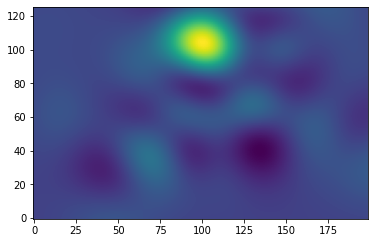

In [85]:
rbfi = Rbf(latitude, longitude, zvalue,function='gaussian')
di = rbfi(grid_x, grid_y)

mp.imshow(di.T, origin="lower")

grid_x# mp.contourf(grid_x, grid_y, zi, cmap=mp.cm.jet)
# mi = np.min(np.hstack([di.ravel(), zvalue.values]))
# ma = np.max(np.hstack([di.ravel(), zvalue.values]))

# c1 = mp.imshow(di.T, origin="lower", vmin=mi, vmax=ma)
# mp.colorbar(c1, shrink=0.67)
# mp.show()

In [106]:
import geojsoncontour

#Converting matplotplib contour plot to geojson
geojson = geojsoncontour.contourf_to_geojson(
        contourf=cs,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

#reading geojson as dict
price_geojson=eval(geojson)

In [109]:
sensors_map=folium.Map(tiles="cartodbpositron")
for location_id, location_info in location_dict.items():
    folium.Marker([location_info["coordinates"][1], location_info["coordinates"][0]],
                  tooltip=location_info['label']).add_to(sensors_map)
folium.GeoJson(
        geojson,
        style_function=lambda x: {
            'color':     x['properties']['stroke'],
            'weight':    x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity':   0.4,
        }).add_to(sensors_map)

sensors_map.fit_bounds(sensors_map.get_bounds())
display(sensors_map)

## Timelapse of the Folium Images
Reference :
1) https://towardsdatascience.com/how-to-make-an-animated-gif-map-in-python-using-folium-and-imageio-91d3fc60d084

2) https://towardsdatascience.com/adding-text-on-image-using-python-2f5bf61bf448

In [ ]:
html_path="./timelapse"
if os.path.exists(html_path):
    shutil.rmtree(html_path)
os.makedirs(html_path)

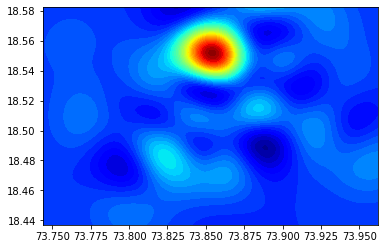

In [158]:
for i in range(1,30):
    interpolate_pollutant('co2',i,1,16)

In [159]:
import fileinput
html_path="./timelapse/"
for i in range(1,30):
    with fileinput.FileInput(html_path + str(i) + '_1_2022_16.html', inplace=True) as file:
        for line in file:
            print(line.replace('zoomControl: true', 'zoomControl: false'), end='')

In [163]:
# os.chdir('../')
os.getcwd()


'D:\\Smal Cities pllution tracking\\Smart-City-Pollution-Tracking'

In [164]:
# Convert html files to png (screenshot each html page)
# We use a delay because we dont want to take a screenshot of the browser before the map is loaded
delay=5

os.chdir(html_path)

for i in range(1,30):
    fn= str(i) + '_1_2022_16.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)

    browser = webdriver.Firefox(executable_path="D:\Smal Cities pllution tracking\Smart-City-Pollution-Tracking\geckodriver.exe")    
    browser.get(tmpurl)

    #Give the map tiles some time to load
    time.sleep(delay)
    browser.save_screenshot(str(i) + '_1_2022_16.png')
    browser.quit()

C:\Users\Somesh\AppData\Local\Temp/ipykernel_24180/2262485603.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Firefox(executable_path="D:\Smal Cities pllution tracking\Smart-City-Pollution-Tracking\geckodriver.exe")


In [165]:
image_path = Path()

images = list(image_path.glob('*16.png'))

In [150]:
name=str(images[0]).strip('(' or ')')

In [166]:
myFont = ImageFont.truetype('arial.ttf', 30)

In [167]:
image_list = []
for file_name in images:
    img = Image.open(file_name)
    I1 = ImageDraw.Draw(img)
    name=str(file_name).strip('(' or ')')
    I1.text((10, 10), name, font=myFont, fill =(255, 0, 0))
    img.save(file_name)
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite('modifiedMap.gif', image_list, fps=2)

C:\Users\Somesh\AppData\Local\Temp/ipykernel_24180/2079447854.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_list.append(imageio.imread(file_name))


### Answering the question

#### Specify major pollutant in the city

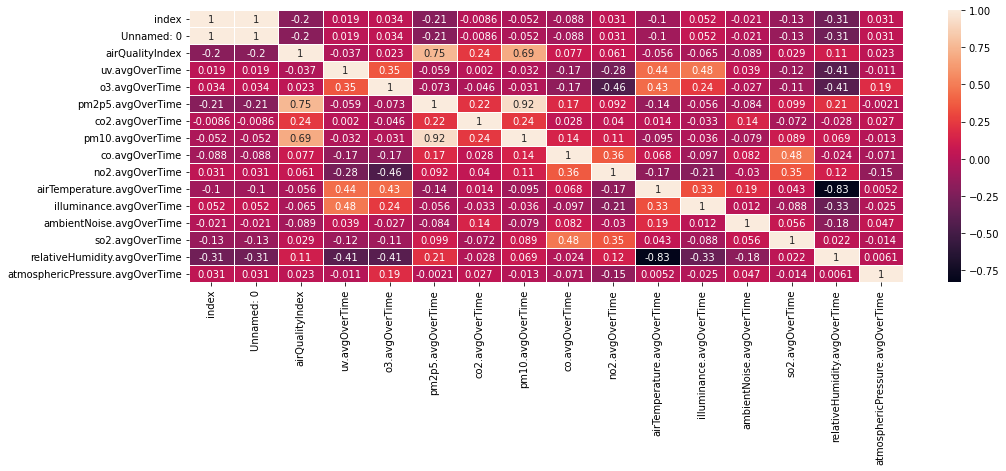

In [20]:
mp.figure(figsize = (16,5))
dataplot=sns.heatmap(pune_aqm.corr(), linewidths=1, linecolor='white',annot=True)
mp.show()

<p> Here we can find out a strong negative correlaation between relative humidity and average temperature. and we can also a strong positive  corelation between pm2p5 and airquality index and pm2p5 and pm10 as well as pm10 airquality </p>

In [27]:
pune_aqm.groupby('aqiMajorPollutant').count()['index']

aqiMajorPollutant
CO       16020
NO2      20485
O3        1987
PM10     16637
PM2.5    44171
Name: index, dtype: int64

<p> <b>Major pollutant in the city are :</b> 
</p>

1. PM 2.5
2. NO2
3. PM10
4. CO